In [ ]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)

2.5.1+cu124


## PyTorch Workflow

* Prepare and load data
* Build model
* Fit the model to training data
* Make predictions and evaluate model
* Save the model and load the model

## Preparing and Loading Data

In [ ]:
# Creating known data

weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # add extra dimension
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
len(X), len(y)

(50, 50)

In [ ]:
# Train-Test Split

train = int(0.8 * len(X))

X_train, y_train = X[:train], y[:train]
X_test, y_test = X[train:], y[train:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label = "Training Data")
    plt.scatter(test_data, test_labels, c="y", s=4, label = "Testing Data")
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label = "Predictions")
    plt.legend(prop={"size": 14})
    plt.show()

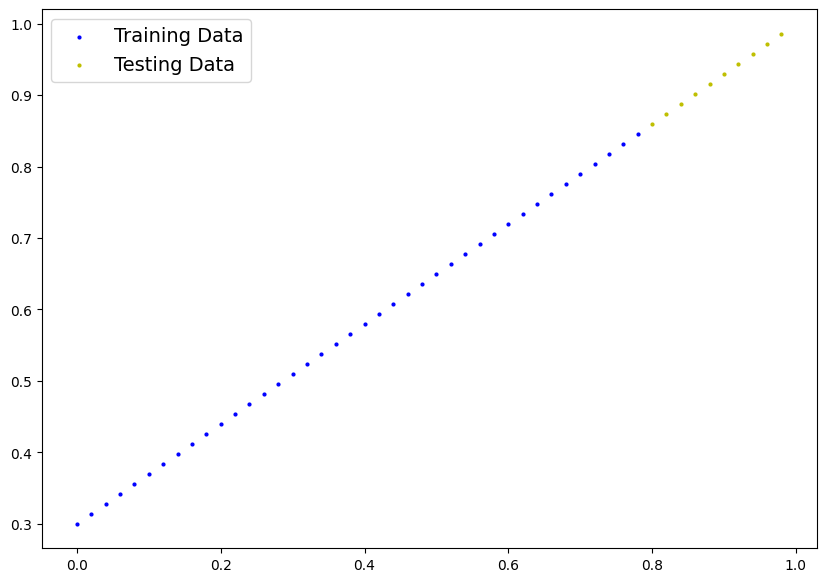

In [ ]:
plot_predictions(X_train, y_train, X_test, y_test)

## Making Model

Almost everything in PyTorch inherits from nn.Module. Its the base class for all neural network modules

In [ ]:
class LinearRegressionModel(nn.Module):
  def __init__(self): # Initialize model parameters/layers
    super().__init__()
    # nn.Parameter is a kind of Tensor that is to be considered a module parameter
    self.weights = nn.Parameter(torch.randn(1, # Random initial weight
                                            requires_grad=True, # Track for gradients; used with torch.autograd
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """
    Defines forward computation; any subclass of nn.Module must override this method
    """
    return self.weights * x + self.bias # Linear regression

The learnable parameters (i.e. weights and biases) of a torch.nn.Module model are contained in the model’s parameters (accessed with model.parameters()). A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor

In [ ]:
# Check model params

torch.manual_seed(42)
model=LinearRegressionModel()

list(model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named params

model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# Start with random numbers and progress towards ideal params
# Predictions with inference_mode()

with torch.inference_mode(): # Inference mode requires no gradient tracking
  y_preds = model(X_test) # inference_mode is preferred way

# OR:

with torch.no_grad():
  y_preds = model(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

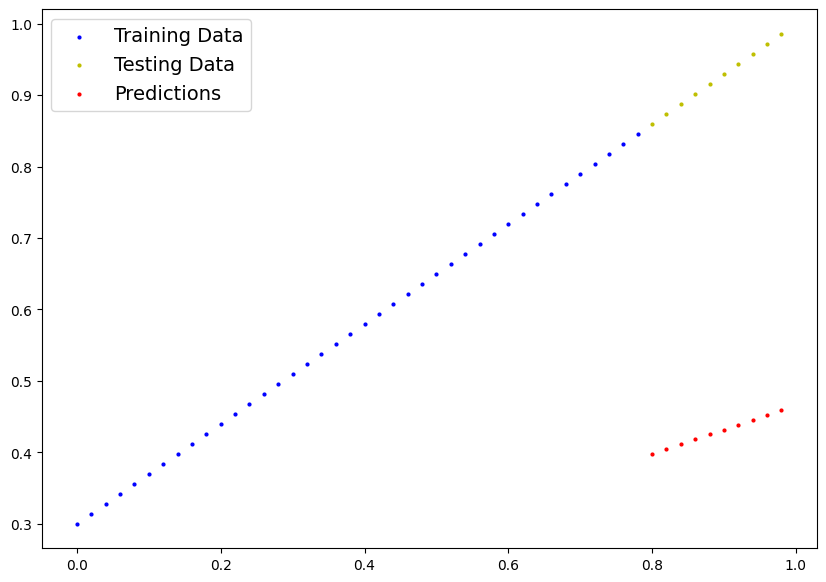

In [ ]:
plot_predictions(X_train, y_train, X_test, y_test, predictions = y_preds)

Now these are random predictions

In [ ]:
y_preds = model(X_test) # Similiar, but does gradient tracking (more computation)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

## Training

**Loss Function:**  Measures how wrong your model's predictions (e.g. y_preds) are compared to the truth labels (e.g. y_test); lower the better.

* Mean absolute error (MAE) for regression problems (torch.nn.L1Loss()).

* Binary cross entropy for binary classification problems (torch.nn.BCELoss()).

**Optimizer:**	Tells your model how to update its internal parameters to best lower the loss.

* Stochastic gradient descent (torch.optim.SGD()).
* Adam optimizer (torch.optim.Adam()).

In [ ]:
model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

**params** is the target model parameters you'd like to optimize (e.g. the weights and bias values we randomly set before).


**lr** is the learning rate you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates

### Training loop

* **Forward pass**	The model goes through all of the training data once, performing its forward() function calculations;	model(x_train)
* **Calculate the loss**	The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are;	loss = loss_fn(y_pred, y_train)
* **Zero gradients**	The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step;	optimizer.zero_grad()
* **Perform backpropagation on the loss**	Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards";	loss.backward()
* **Update the optimizer (gradient descent)**	Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them;	optimizer.step()

In [ ]:
torch.manual_seed(42)

epochs=150
epoch_count=[]
loss_values=[]
test_loss_values=[]

for epoch in range(epochs):
  model.train() # Set mode to training mode; all params that require grads are tracked

  # Forward pass
  y_pred = model(X_train)

  # Loss calculation
  loss = loss_fn(y_pred, y_train)

  # Zero the gradients
  optimizer.zero_grad()

  # Backprop
  loss.backward()

  # Gradient descent
  optimizer.step()

  # Testing
  model.eval() # Turns off dropout / batch norm
  with torch.inference_mode(): # Turns off gradient tracking
    test_pred = model(X_test) # Forward pass
    test_loss = loss_fn(test_pred, y_test) # Calculate loss

  epoch_count.append(epoch)
  loss_values.append(loss)
  test_loss_values.append(test_loss)
  if epoch % 10 ==0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
    print(model.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

### Testing Loop

* **Forward pass**	The model goes through all of the testing data once, performing its forward() function calculations.	model(x_test)
*	**Calculate the loss**	The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.	loss = loss_fn(y_pred, y_test)
*	**Calulate evaluation metrics (optional)**	Alongside the loss value you may want to calculate other evaluation metrics such as accuracy on the test set.

In [ ]:
model.state_dict()

OrderedDict([('weights', tensor([0.6638])), ('bias', tensor([0.3153]))])

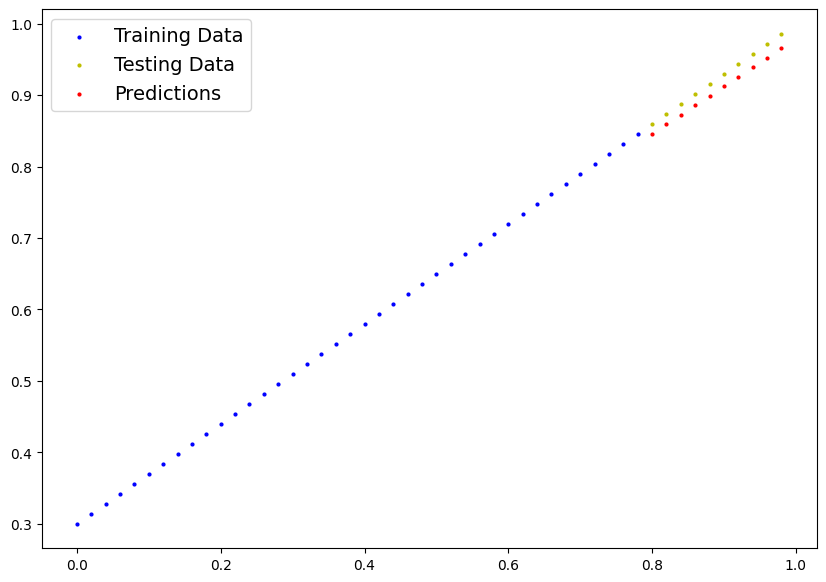

In [ ]:
with torch.inference_mode():
  y_preds = model(X_test)

plot_predictions(X_train, y_train, X_test, y_test, predictions = y_preds)

In [ ]:
loss_values = np.array(torch.tensor(loss_values).to('cpu').numpy())
test_loss_values = np.array(torch.tensor(test_loss_values).to('cpu').numpy())

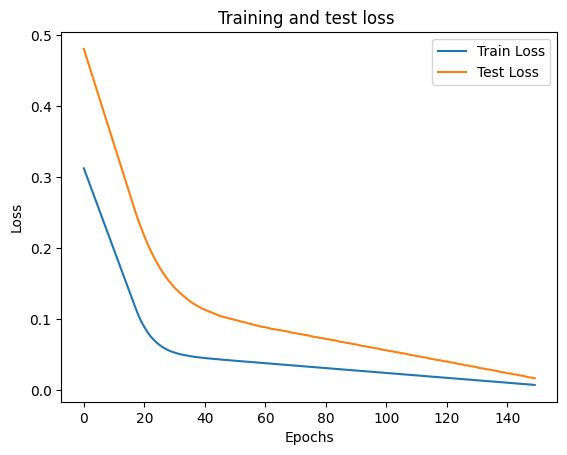

In [ ]:
plt.plot(epoch_count, loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")

plt.title("Training and test loss ")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

## Saving and Loading Models

* **torch.save**	Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save.
* **torch.load**	Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).
* **torch.nn.Module.load_state_dict**	Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.

* A common PyTorch convention is to save models using either a .pt or .pth file extension.

In [ ]:
# Saving
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "simple_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/simple_model.pth


In [ ]:
!ls

models	sample_data


In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1526 Feb  4 02:47 simple_model.pth


In [ ]:
# Loading

# Since we saved state_dict, we'll cretate new instance of model and load saved state_dict into that

loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))
loaded_model.state_dict()


<ipython-input-23-2a64a1188bbc>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))


OrderedDict([('weights', tensor([0.6638])), ('bias', tensor([0.3153]))])

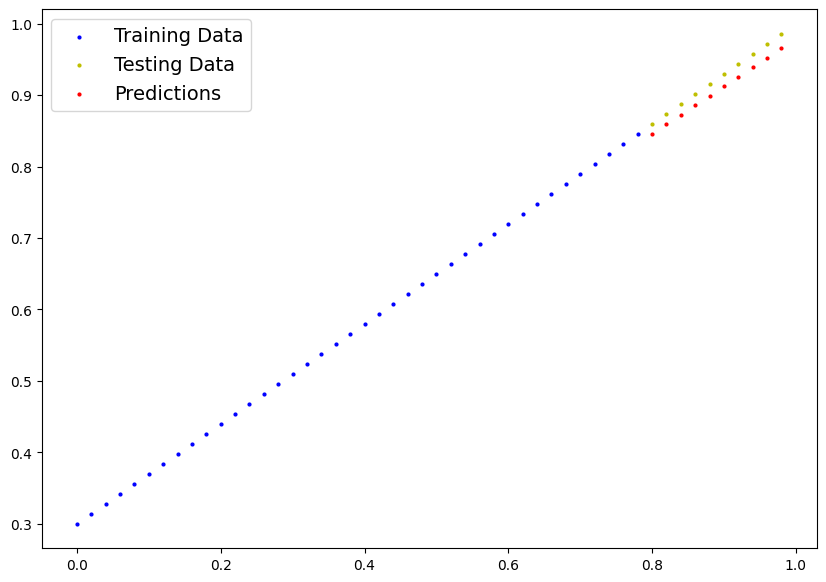

In [ ]:
loaded_model.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model(X_test)

plot_predictions(X_train, y_train, X_test, y_test, predictions = loaded_model_preds)